# AOMA with reference based Cov-SSI from STRID package

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
import dataloader_halogaland.dataloader as dl
from dataloader_halogaland.plot import welch_plot, stabilization_diagram
import os
import koma.oma, koma.plot
import koma.clustering
import strid
from time import time

/Users/emilneby/miniforge3/envs/master/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data from hdf5 file format

In [2]:
analysis_length = 30 #minutes
cutoff_frequency = 1 #Hz
bridgedeck_only = True

loader= dl.HDF5_dataloader(os.getcwd()+'/../../../../../../../Volumes/LaCie/Halogaland_sixth_try.hdf5', bridgedeck_only=bridgedeck_only)

In [16]:
acc = loader.load_all_acceleration_data(loader.periods[15], preprosess=True, cutoff_frequency=cutoff_frequency, filter_order=10)
print(len(acc[:,0]))
acc = acc[:2*cutoff_frequency*60*analysis_length,:]
acc = acc.transpose()
print(acc.shape)

57600
(48, 3600)


### Reference based Cov-SSI from strid-package

In [17]:
#Parameters
i = 24 #number of block rows
s = 6
fs = 2
orders = np.arange(2, 100+2, 2) #orders to perform system identification for
#stabcrit = {'freq': 0.05, 'damping': 0.1, 'mac': 0.1} # Default

In [18]:
#Indices for reference channels:
"""
0-21 are channels for x-dirdction, we discard them due to assumed little excitation.
Indices [1,3,5,7,11,13,17,19] will give channels for one section of the bridge excluding towers and hangers. Add 22 and 44 respectively to get y and z direction respectively.
"""

"""
When bridge deck only channels are included, there are 16 channels in total.
Indices [0, 2, 4, 6, 8, 10, 12, 14]
"""

if bridgedeck_only:
    ix_references_y = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+16)
    ix_references_z = (np.array([0, 2, 4, 6, 8, 10, 12, 14])+32)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()
else:
    ix_references_y = (np.array([1,3,5,7,11,13,17,19])+22)
    ix_references_z = (np.array([1,3,5,7,11,13,17,19])+44)
    ix_references = np.concatenate((ix_references_y, ix_references_z)).tolist()



print((ix_references))

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46]


In [19]:
ssid = strid.CovarianceDrivenStochasticSID(acc, fs, ix_references)

In [20]:
#Perform system identification
t0 = time()
modes = {}
for order in orders:
    A, C, G, R0 = ssid.perform(order, i)
    modes[order] = strid.Mode.find_modes_from_ss(A, C, ssid.fs)

t1 = time()
print("Execution time = " + str(t1-t0))

Execution time = 2.0136330127716064


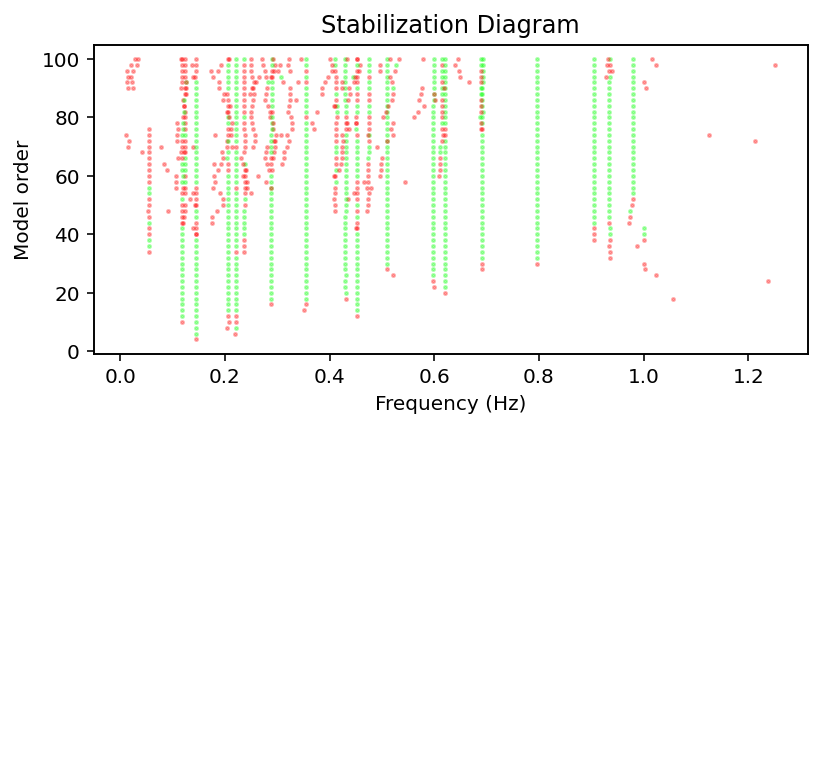

In [21]:
#Filtering routine, pick "stable" modes
stabdiag = strid.StabilizationDiagram()
stabdiag.plot(modes)
modes = stabdiag.filter_modes(modes)

In [22]:
#Sorting routine, from dictionary based modes into corresponding list with features
orders = []
lambdas = []
phis = []

for order in modes.keys():
    modes_in_order = modes[order]
    for mode in modes_in_order:
        orders.append(order)
        lambdas.append(mode.eigenvalue)
        phis.append(mode.eigenvector)

orders = np.array(orders)
lambdas = np.array(lambdas)
phis = np.array(phis).transpose()

### HDBSCAN to cluster poles from KOMA package

In [23]:
#Pole clustering
pole_clusterer = koma.clustering.PoleClusterer(lambdas, phis, orders, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 0.5})
prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)

#plot_koma.plot_stab_from_KOMA(np.array(omega_n_auto)/2/np.pi, order_auto).savefig("results/realization_" + str(j) + ".jpg")

xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi

### Create stabilization diagram

/var/folders/xg/ddkjb2x96w167hqnv_gjv_v40000gn/T/ipykernel_33095/18250576.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  stab_diag = stabilization_diagram(acc.transpose(), fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)


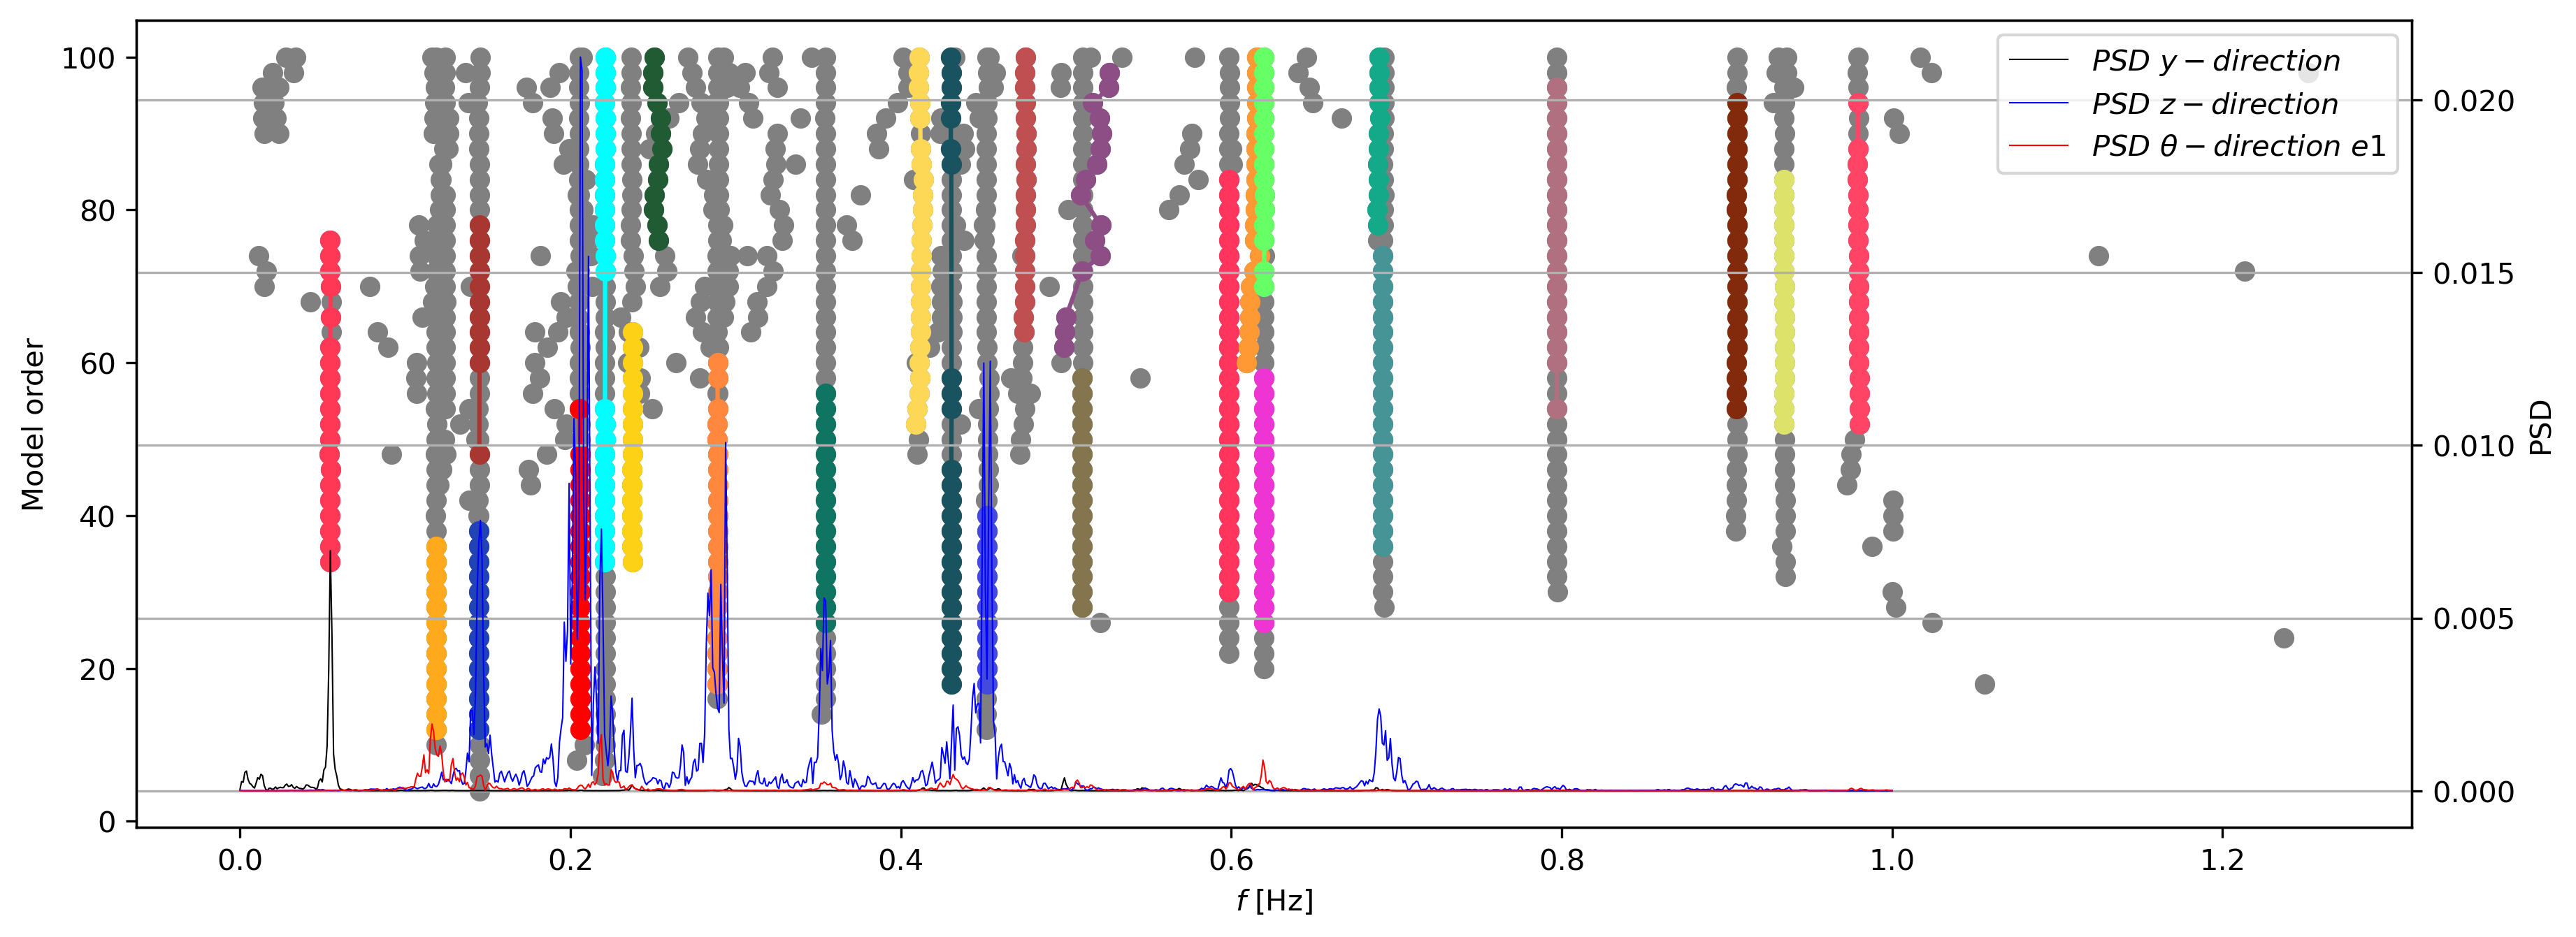

In [24]:
stab_diag = stabilization_diagram(acc.transpose(), fs, 2, (np.array(omega_n_auto)/2/np.pi), np.array(order_auto), all_freqs=np.abs(lambdas)/2/np.pi, all_orders=orders)
plt.savefig("stabilization_diagram.jpg")

In [25]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,0.054522,1.432427
1,0.118721,5.305232
2,0.144718,2.800002
3,0.144914,2.863533
4,0.205833,1.961500
5,0.220962,1.920511
6,0.237524,0.869519
7,0.252358,2.791584
8,0.289070,1.682417
9,0.354336,1.074299


In [26]:
from python_appendix import OMA_functions as OMA

# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)

grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)

print(len(grouped_phis))

phi_extracted = np.zeros((len(grouped_phis), 48))
print(phi_extracted.shape)

for i in range(len(grouped_phis)):
    #print(len(grouped_phis[i]))
    #print(type(grouped_phis[i]))
    for j in range(np.shape(grouped_phis[i])[0]):
       phi_extracted[i,j] = (np.real(np.mean(grouped_phis[i][j])))

phi_extracted = phi_extracted.transpose()

26
(26, 48)


/Users/emilneby/PyCharmProjects/AOMA_Halogaland/python_appendix/OMA_functions.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(4, 1, figsize=(7,10))


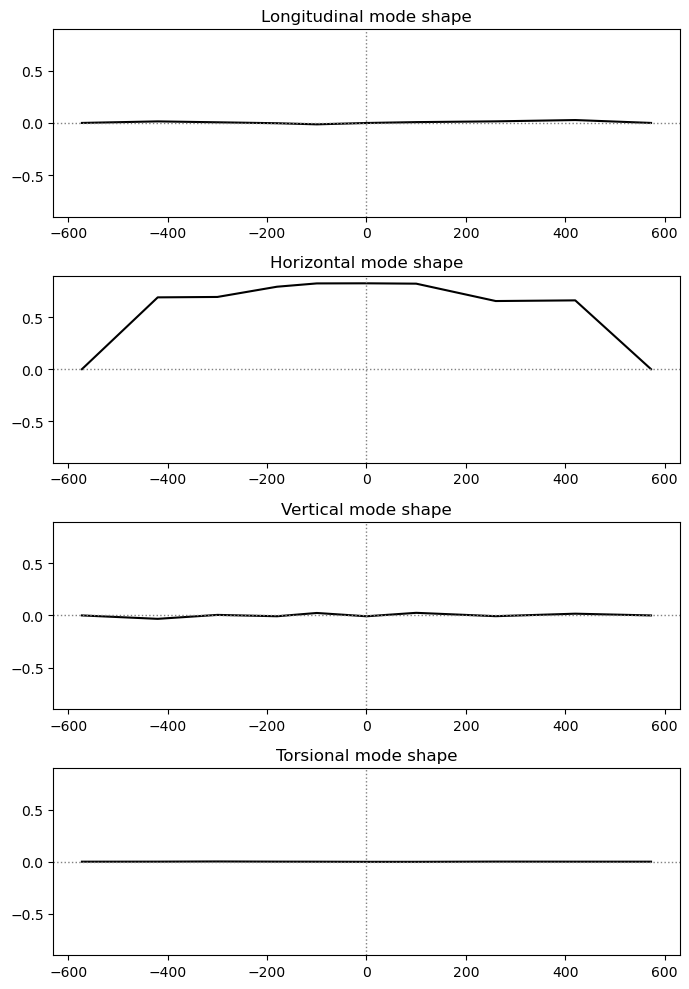

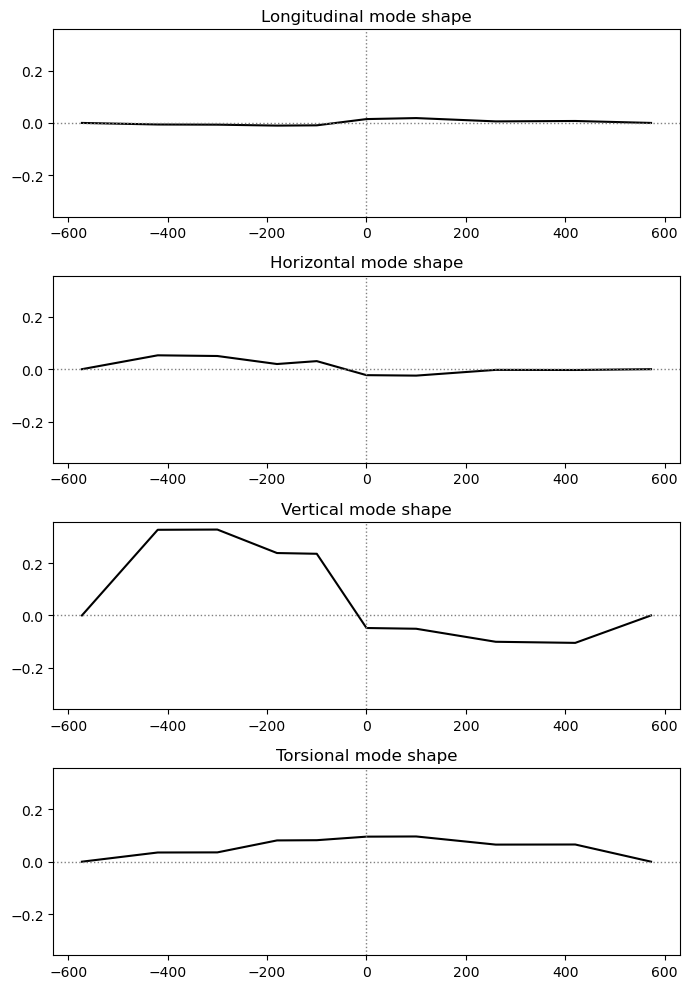

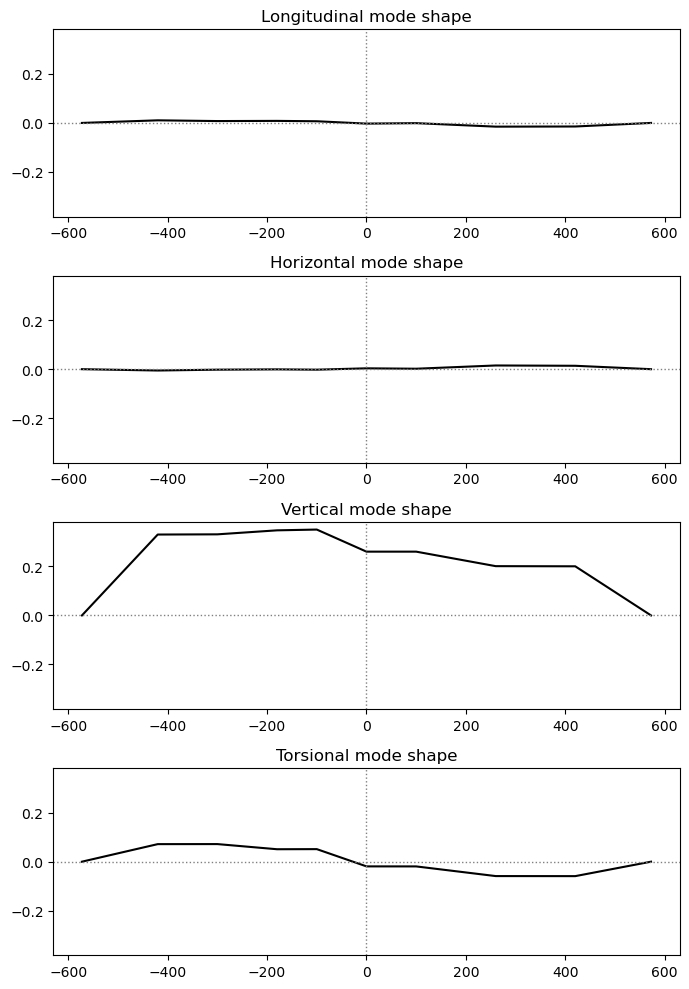

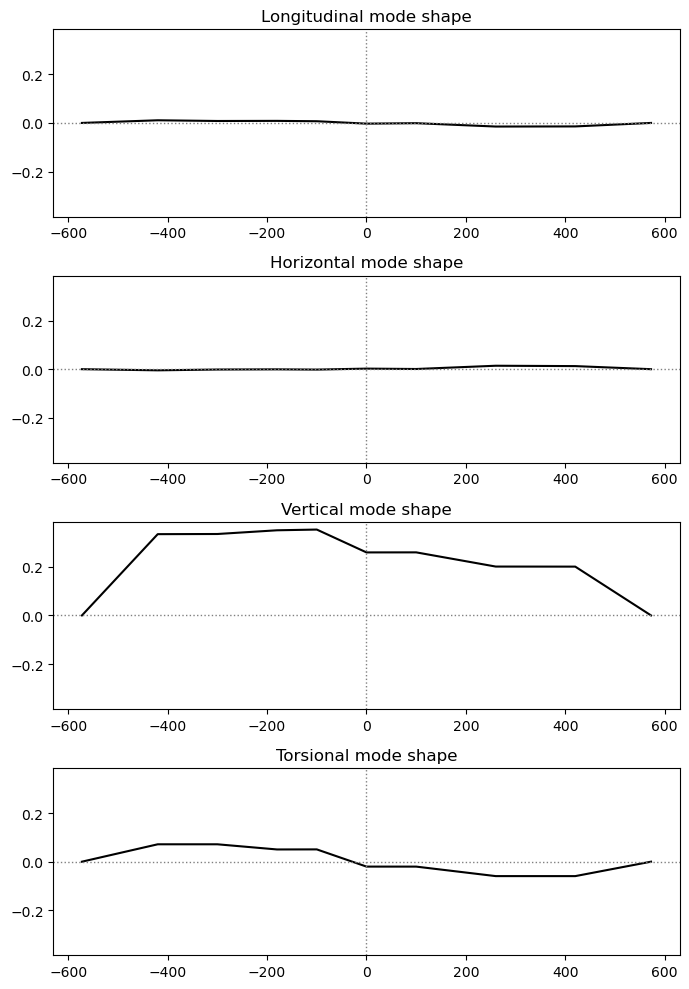

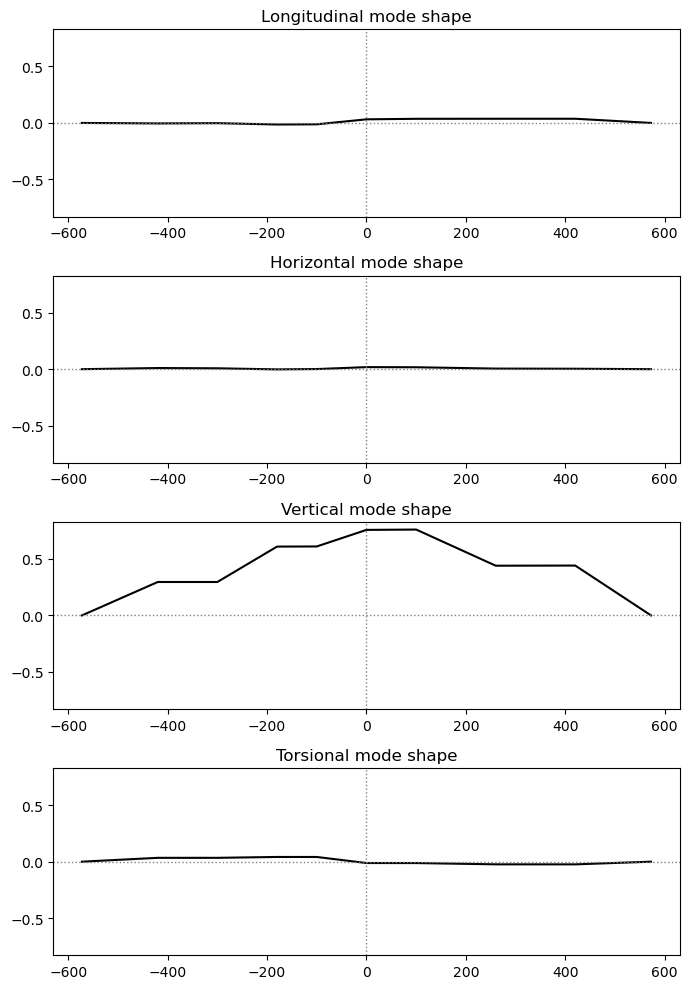

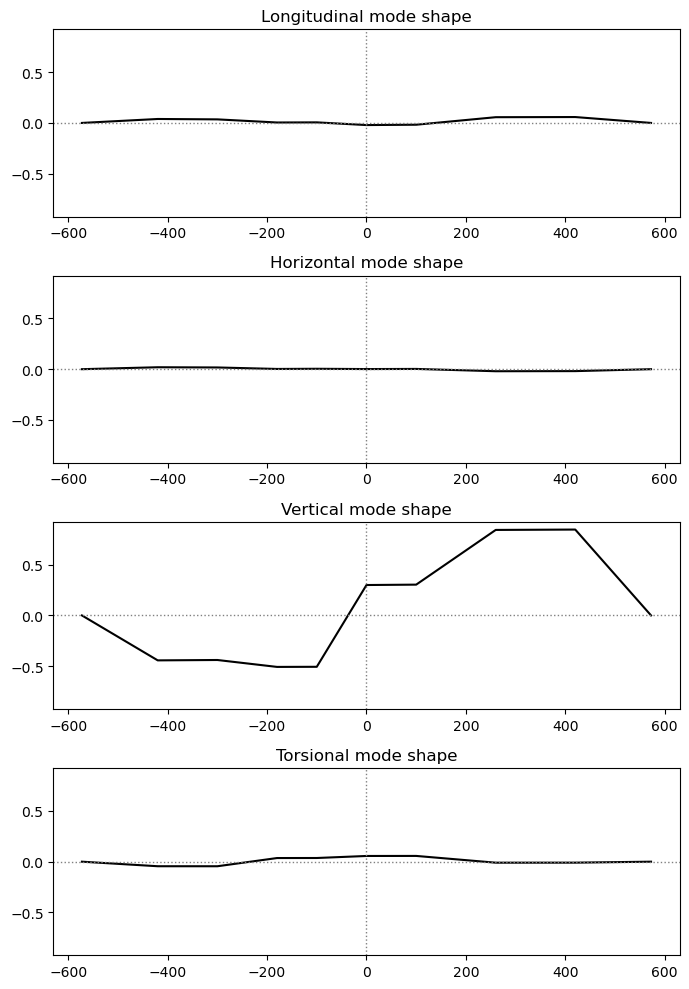

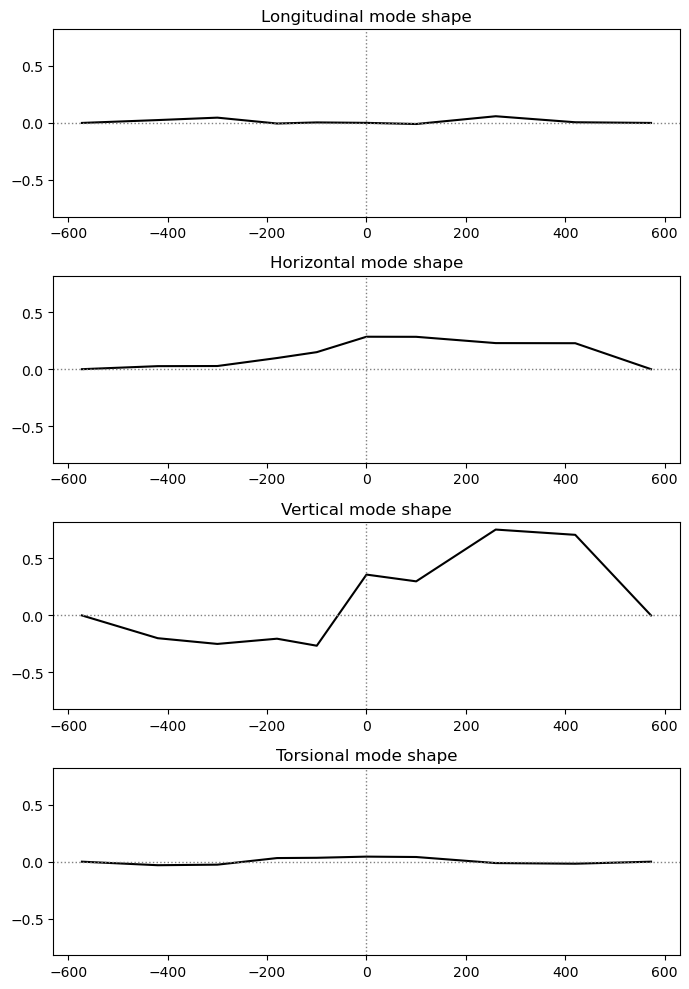

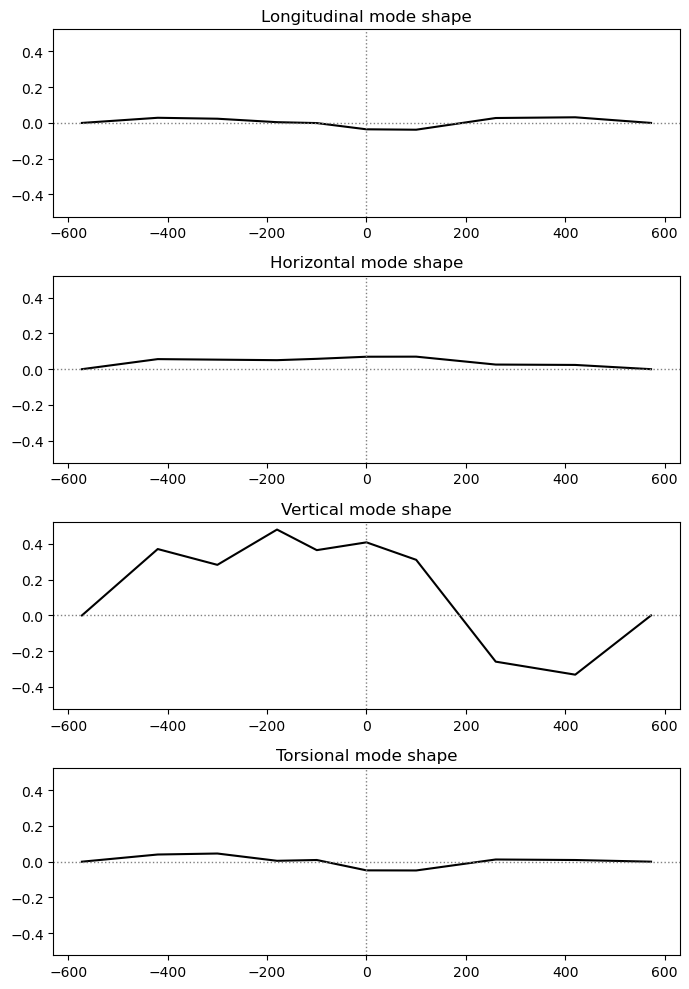

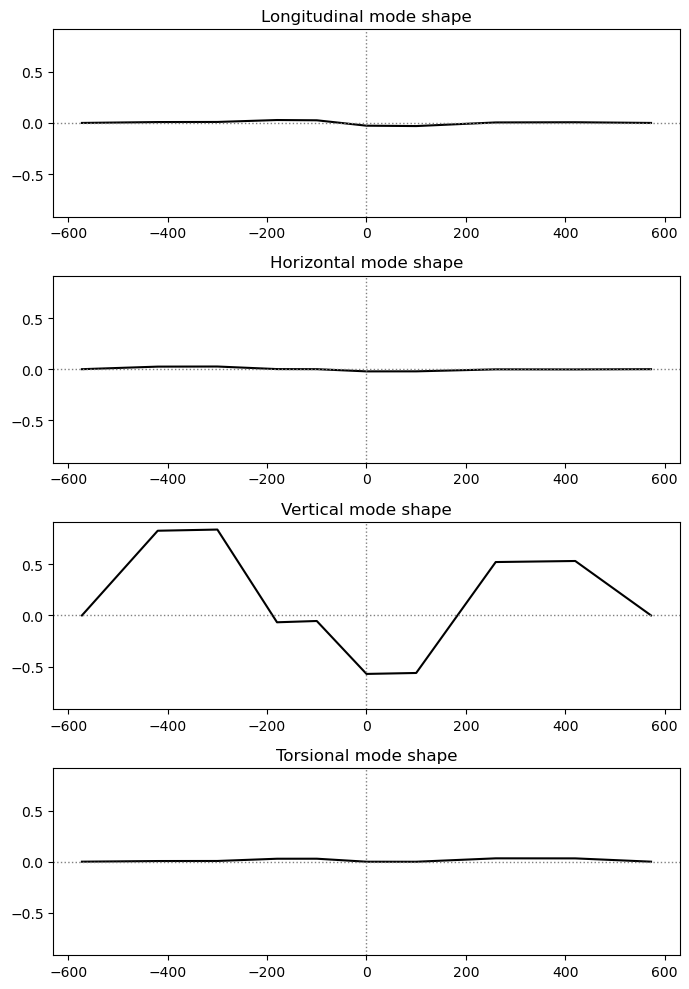

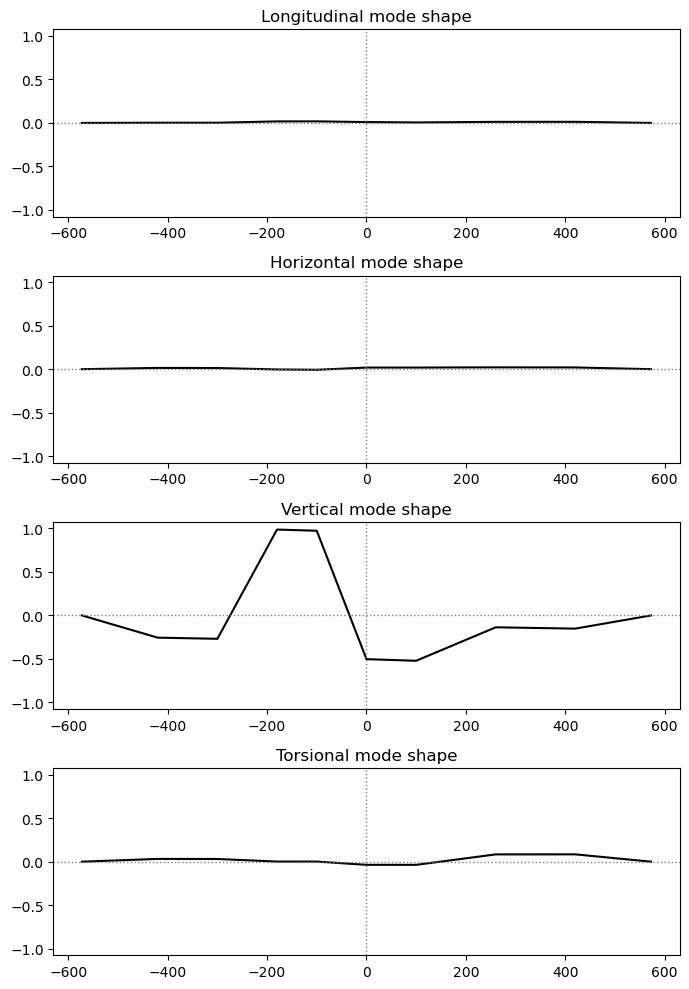

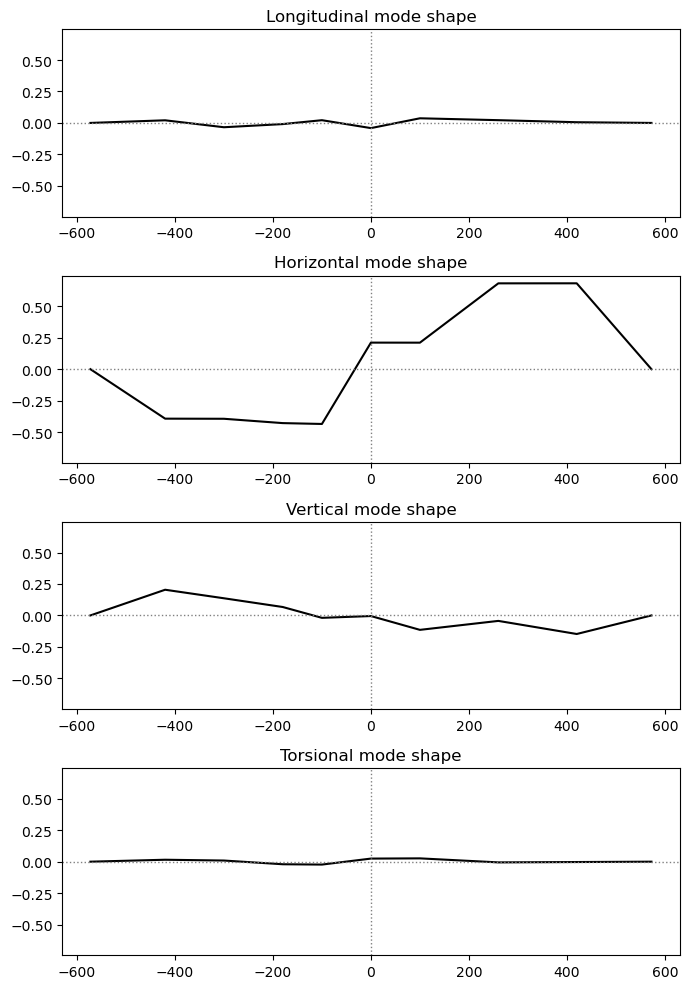

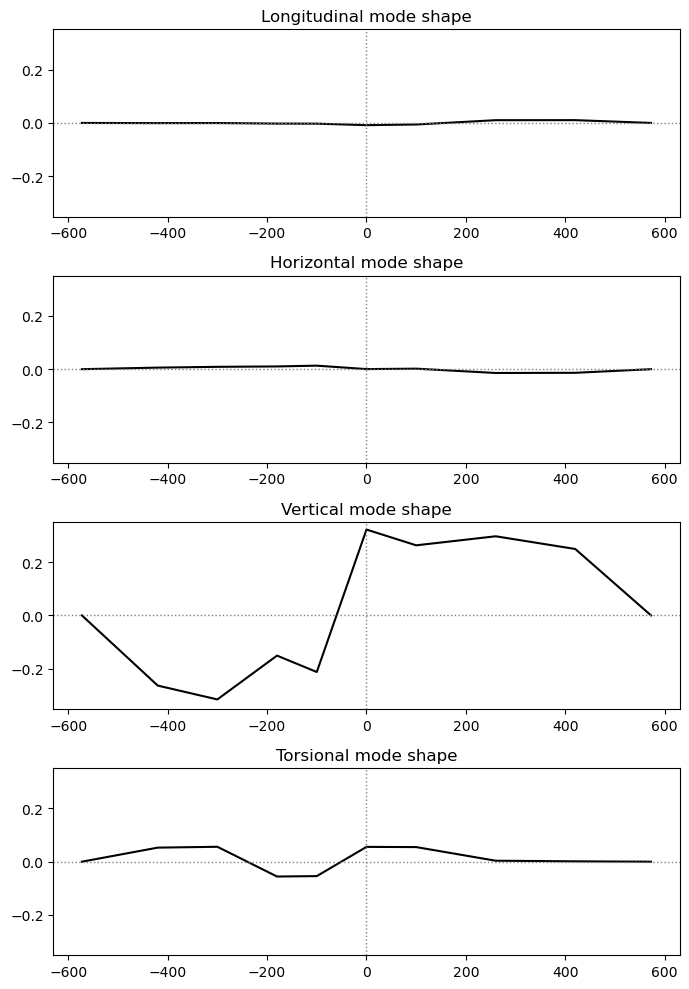

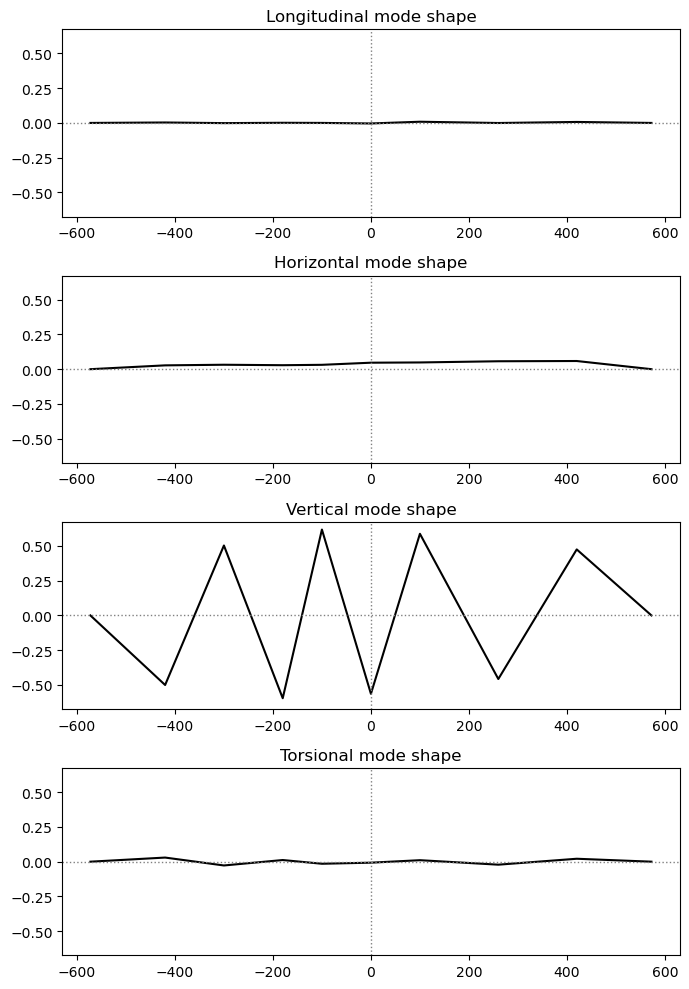

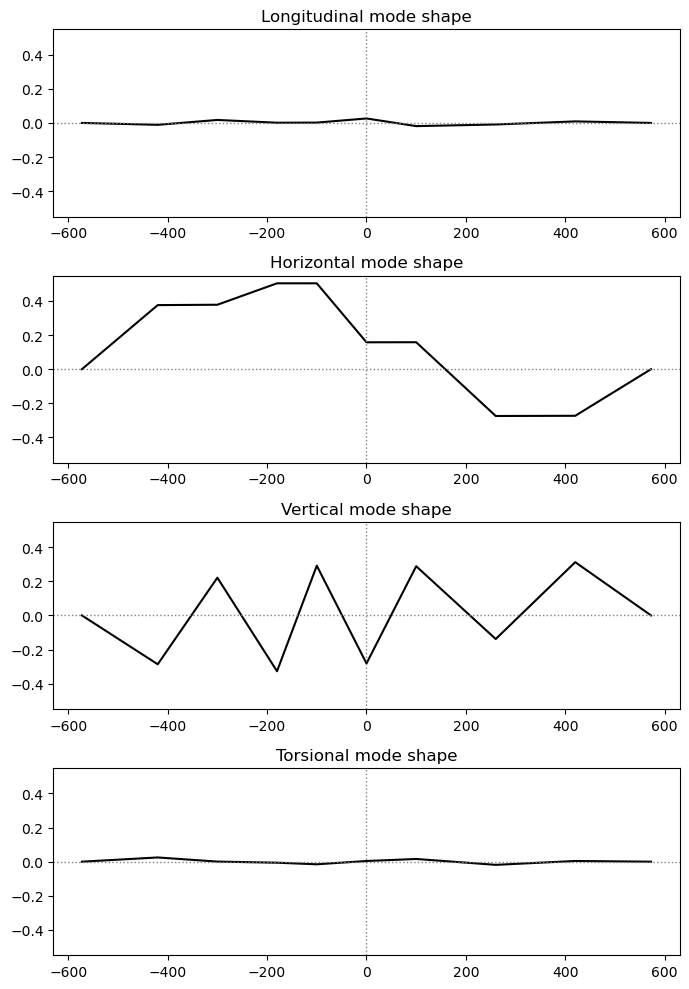

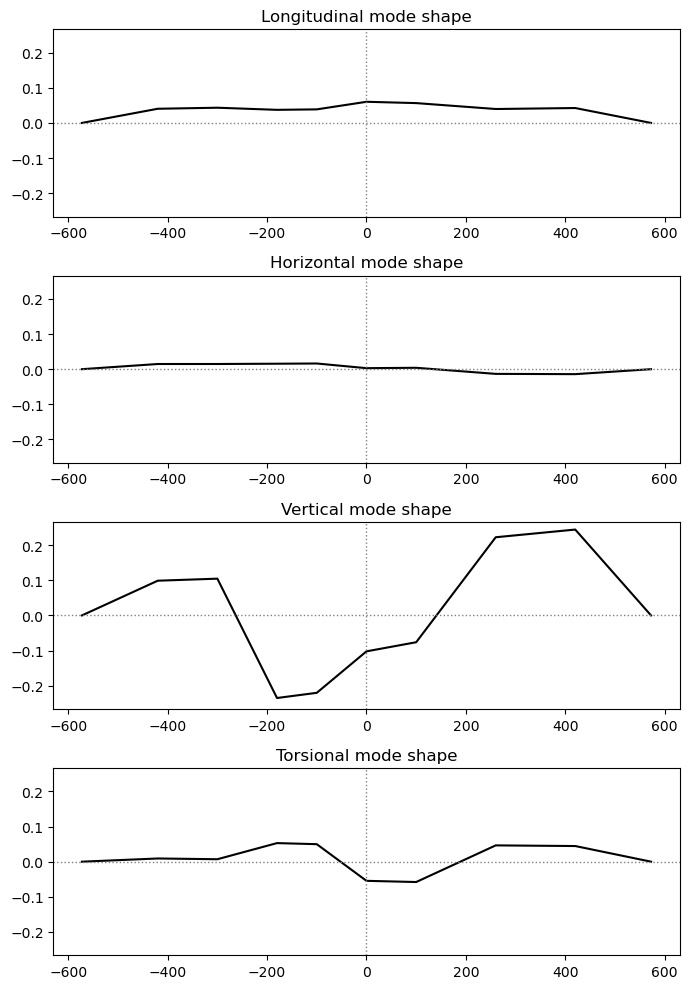

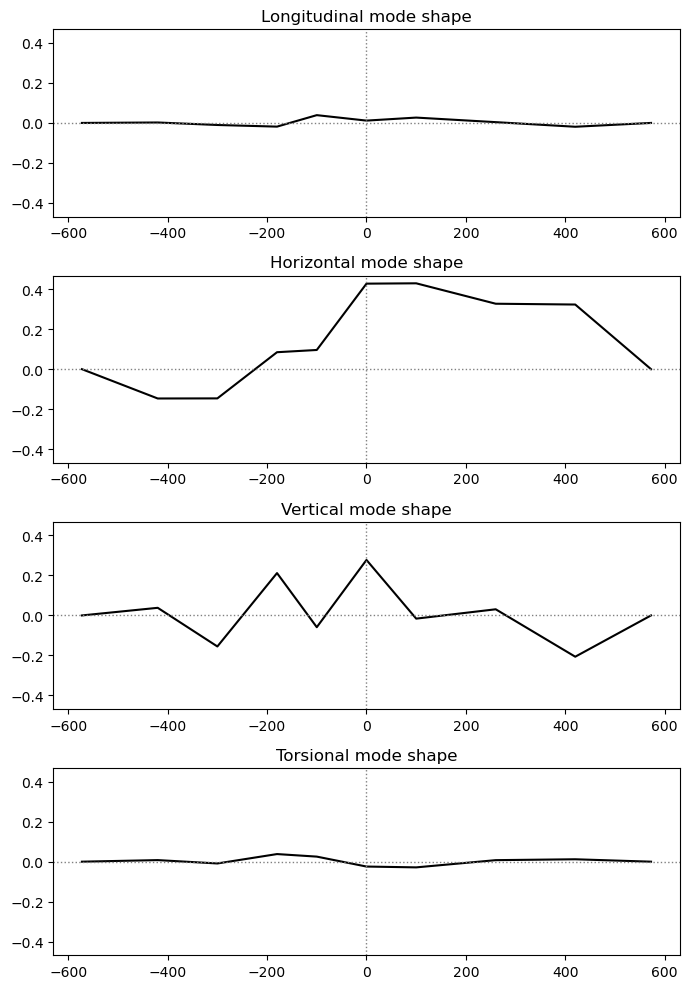

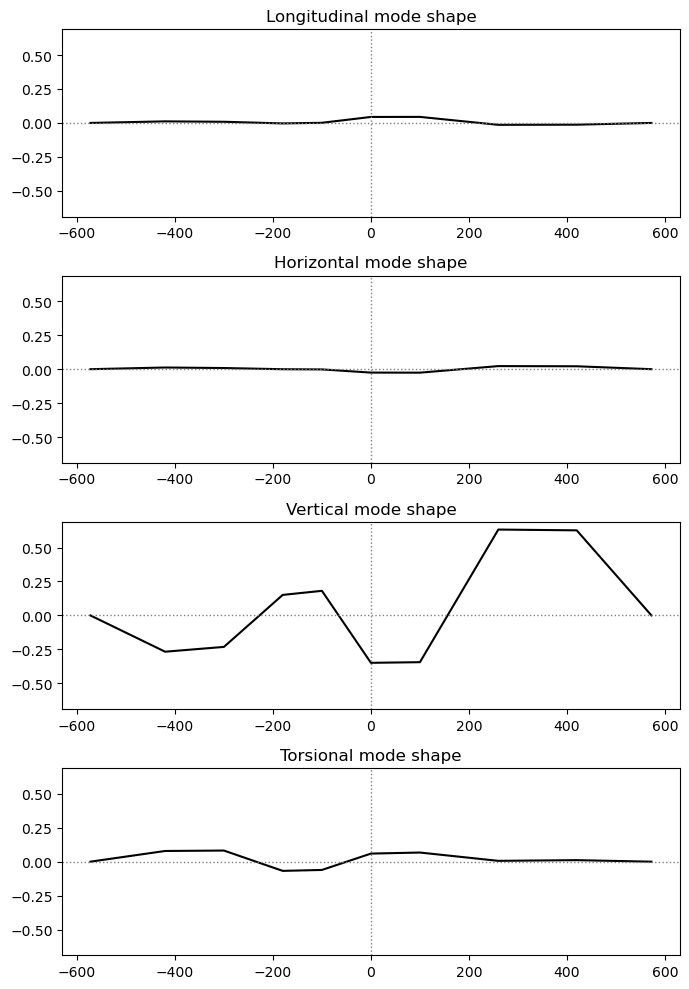

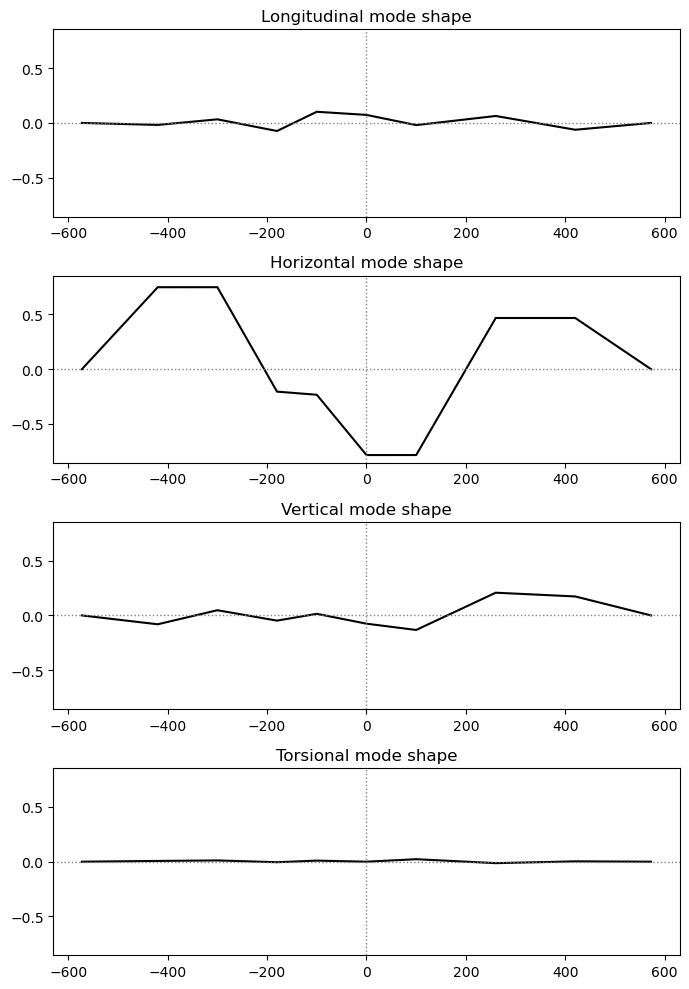

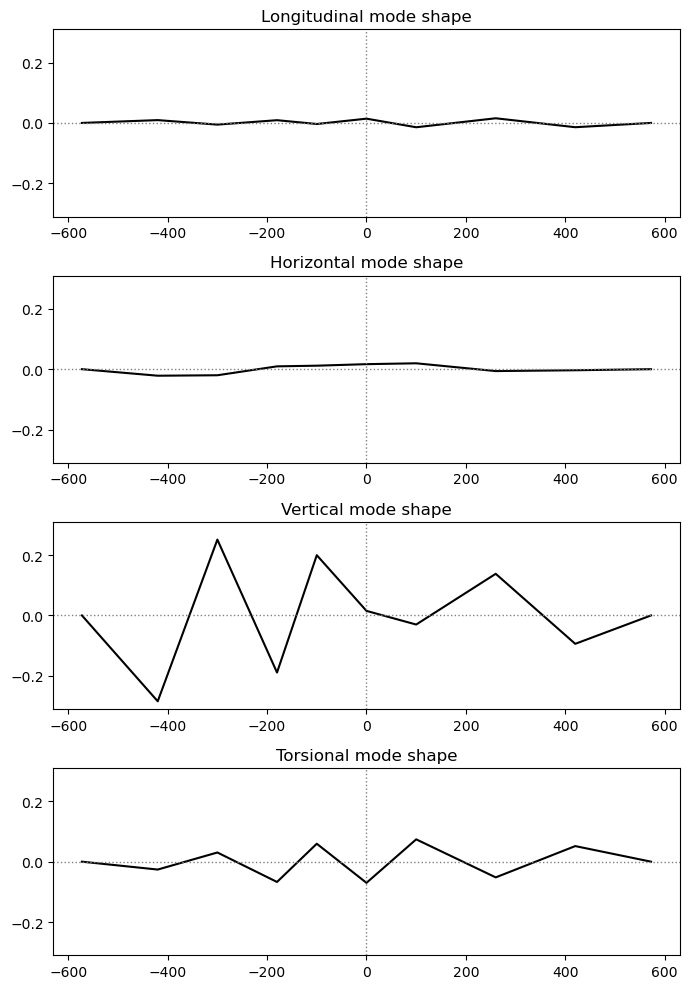

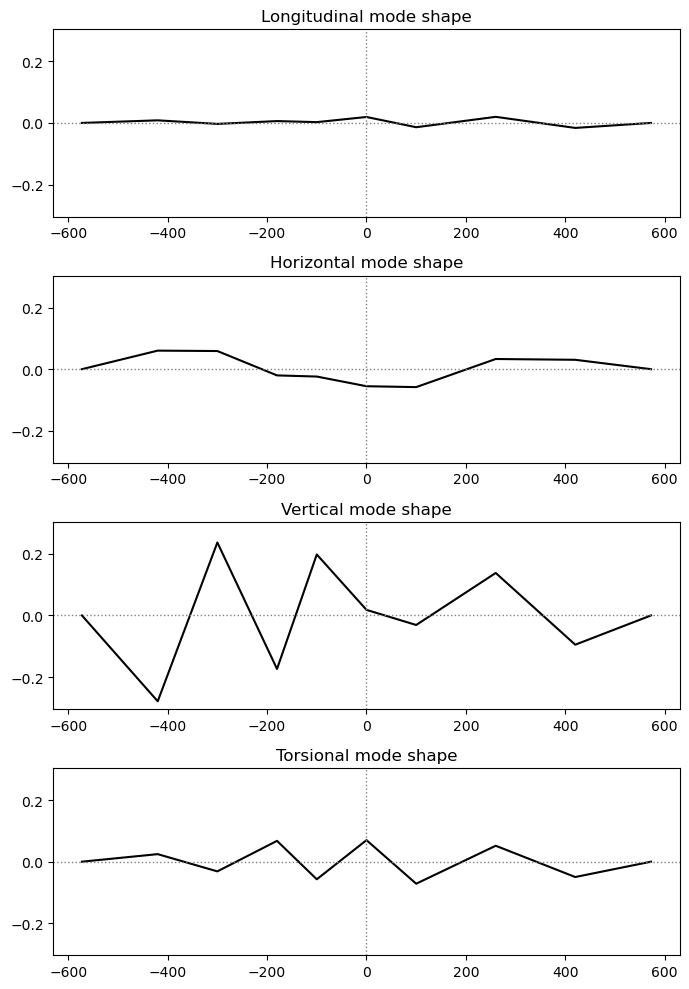

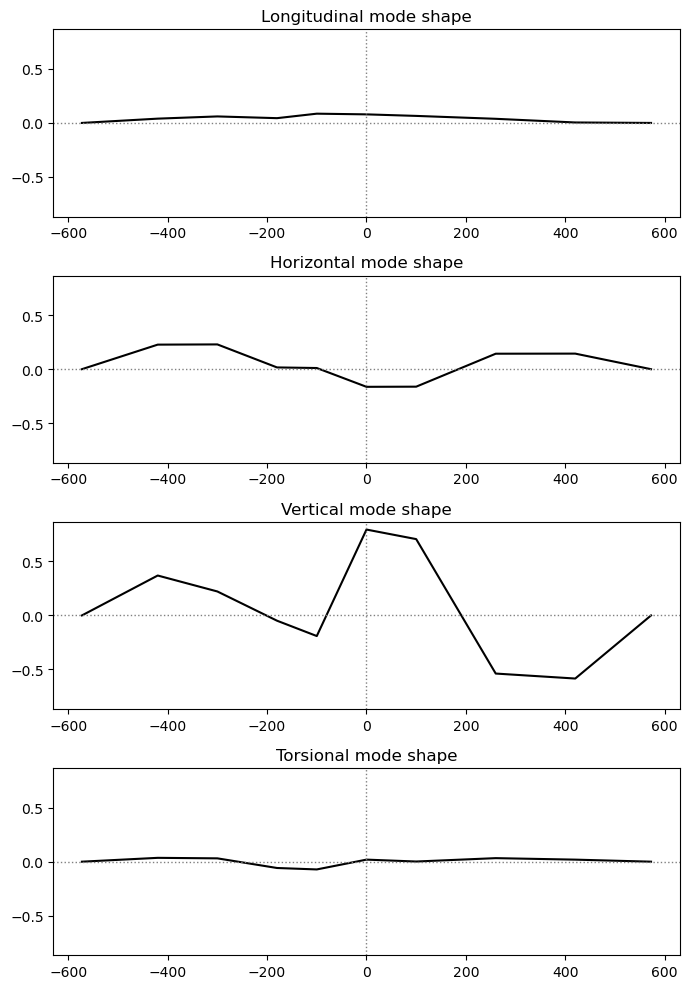

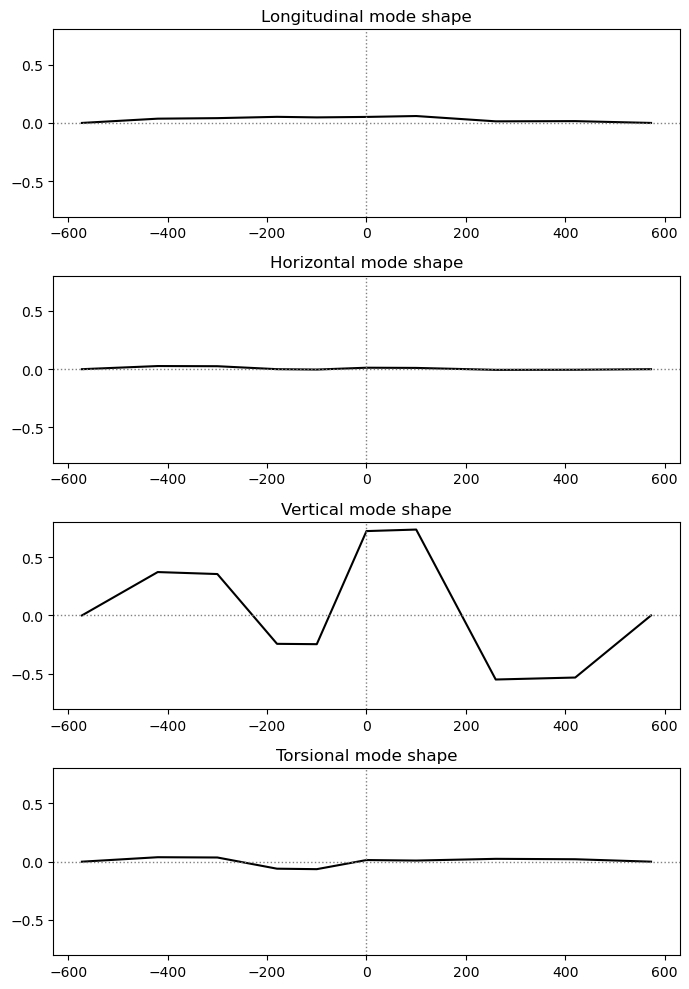

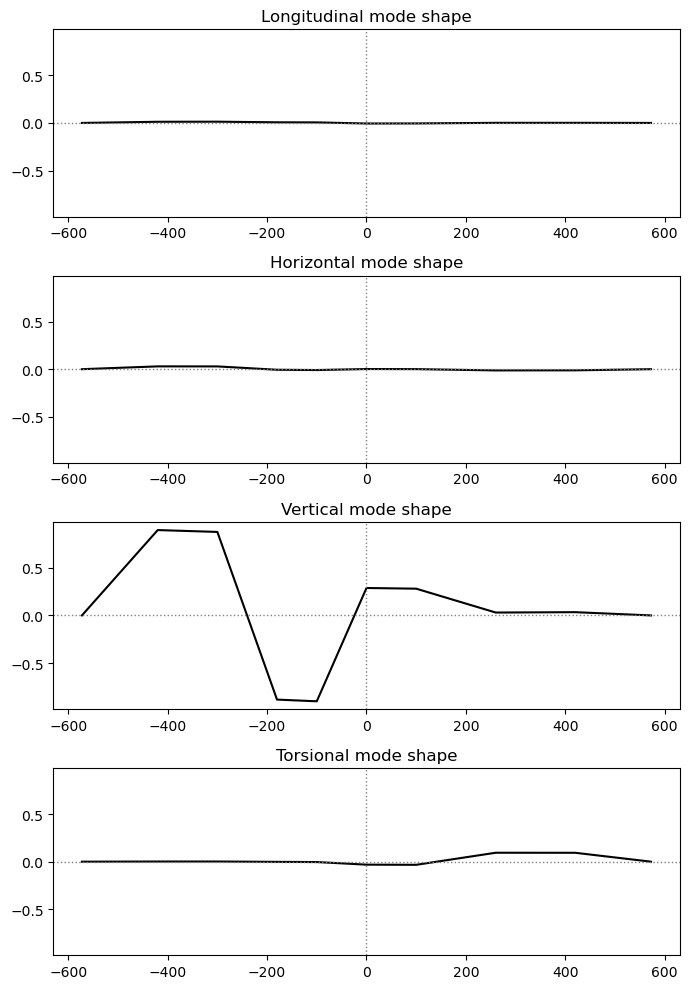

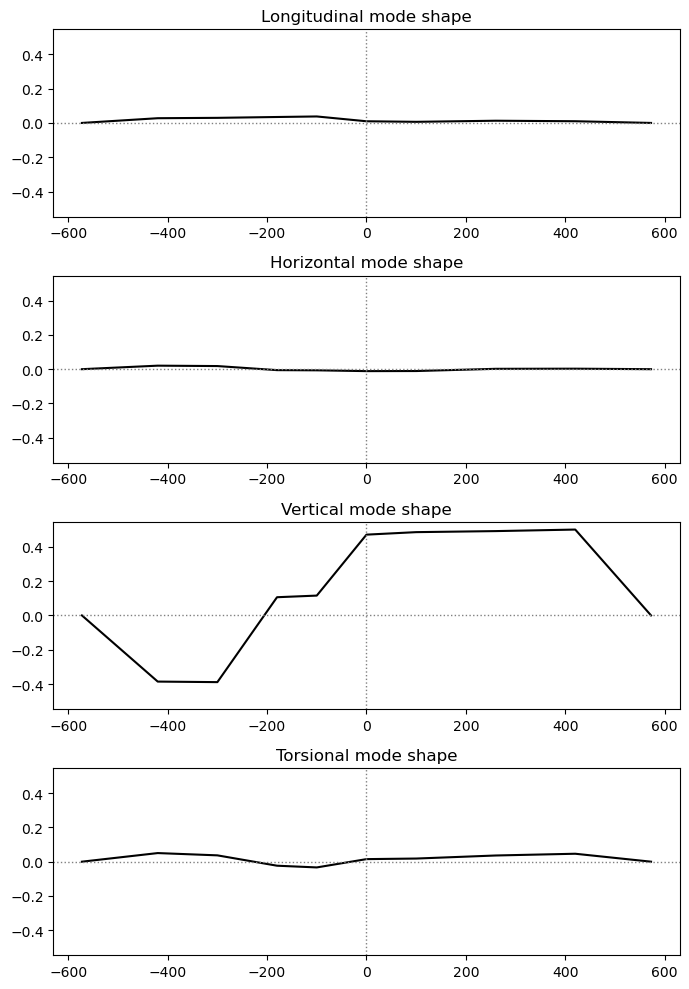

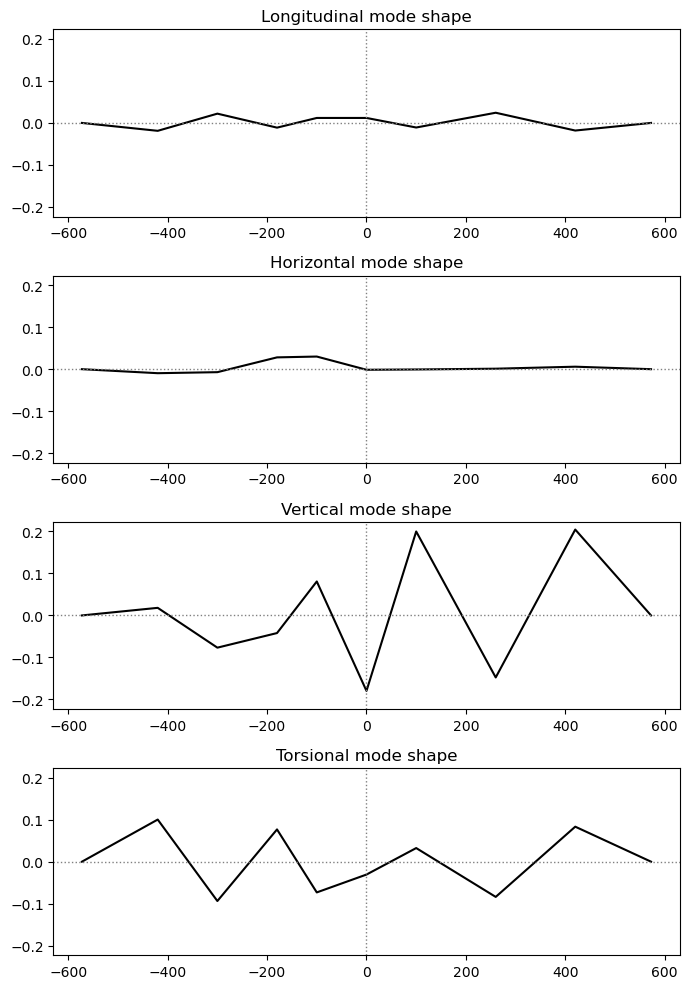

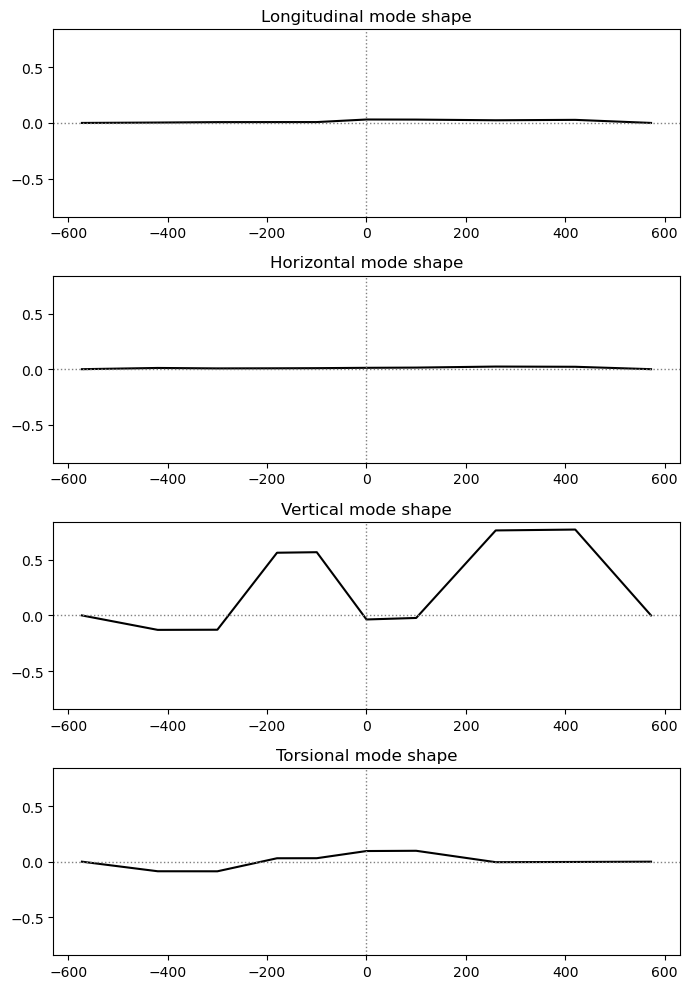

In [27]:
for i in range(phi_extracted.shape[1]):
    fig_shape = OMA.plotModeShape(phi_extracted, i)
    plt.savefig("plots/modeshapes/modeshape_mode_" + str(i+1) + ".jpg")